In [10]:
# Visualization of the analytical solution
import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])
import numpy as np

import phd.models.cm.analytical_plate as ap
from phd.config import load_config, copy_config, apply_overrides
from phd.plot.plot_cm import plot_field

from phd.plot import get_current_config as plt_cfg, book_config, book_compact_config, A4_config
book_config.set_as_current()

# Configuration
save_fig = True
save_table = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

# Chapter IV: Physics-Informed Neural Networks for Material Characterization
## IV.1 PINNs for Continuum Mechanics
### IV.1.3 Implementation details: Plate under sinusoidal body-load

W1215 18:29:03.056125   84418 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 18:29:03.060699   84302 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


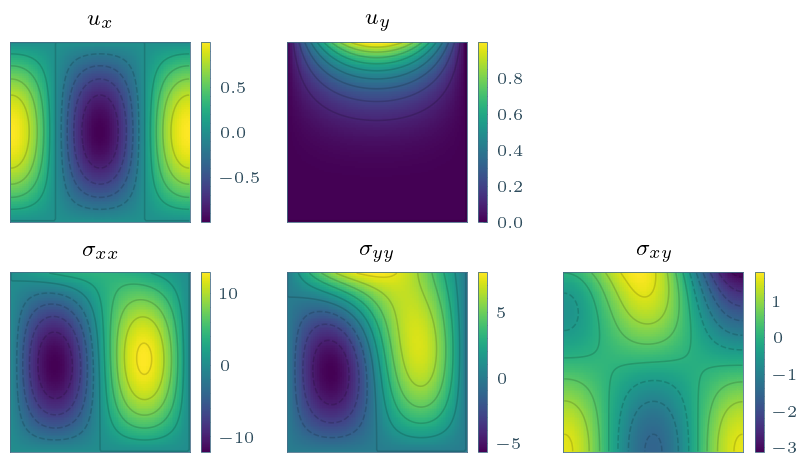

In [2]:
base_config = load_config("analytical_plate")
mat_params = base_config['problem']['material']

x_lin = np.linspace(0, 1, 100)
Xmesh, Ymesh = np.meshgrid(x_lin, x_lin, indexing="ij")
X_input = [x_lin.reshape(-1, 1), x_lin.reshape(-1, 1)]

lmbd, mu, Q = mat_params['lmbd'], mat_params['mu'], mat_params['Q']
sol = ap.exact_solution(X_input, lmbd, mu, Q)

field_names = ap.LATEX_FIELD_NAMES

fig_size = (0.88*plt_cfg().page_width, 0.5*plt_cfg().page_width)
fig, axes = plt.subplots(2, 3, figsize=fig_size, dpi=200)
axes[0, 2].set_visible(False)
axes_plot = axes[0, :-1].flatten().tolist() + axes[1, :].flatten().tolist()

for idx, field in enumerate(field_names.keys()):
    ax = axes_plot[idx]
    art = plot_field(
        ax, Xmesh, Ymesh, sol[:, idx].reshape(Xmesh.shape), cmap='viridis', plot_contours=True
    )
    fig.colorbar(art["im"], ax=ax)
    ax.set_title(field_names[field])

plt.tight_layout()

# save figure
if save_fig:
    figure_folder = "./images"
    os.makedirs(figure_folder, exist_ok=True)
    os.makedirs(figure_folder+"/pdf", exist_ok=True) 
    figure_name = "analytical_plate_solution"
    fig.savefig(os.path.join(figure_folder, figure_name + ".png"), bbox_inches='tight', dpi=300)
    fig.savefig(os.path.join(figure_folder, "pdf", figure_name + ".pdf"), bbox_inches='tight', dpi=300)

## Forward Problem
We benchmark different implementations (PINN/SPINN with mixed/displacement formulation)

In [2]:
# === Forward Problem: SPINN/PINN × mixed/displacement ===

# Run configurations to train (empty list = load all from disk)
configs_to_run = []  # e.g. ["spinn_mixed", "spinn_disp", "pinn_mixed", "pinn_disp"]

# Load base config
base_cfg = load_config("analytical_plate")
base_cfg.task.type = "forward"
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "spinn_mixed": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
}

all_config_names = list(model_variants.keys())
results_forward = {}

# Text labels for plotting
config_text_dict = {
    "spinn_mixed": "SPINN (mixed)",
    "spinn_disp": "SPINN (disp.)",
    "pinn_mixed": "PINN (mixed)",
    "pinn_disp": "PINN (disp.)",
}

# === Train or Load each configuration ===
for config_name in all_config_names:
    run_name = config_name
    should_train = config_name in configs_to_run
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg)
        apply_overrides(cfg, model_variants[config_name])
        
        print(f"Training: {run_name}")
        results = ap.train(cfg)
        
        # Save using problem-specific wrapper
        ap.save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_forward[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_forward[run_name] = ap.load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed


W1215 20:50:26.659126   85970 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1215 20:50:26.662456   85855 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp
Loading: pinn_mixed
Loading: pinn_disp


### Table of the results

In [6]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history
from phd.io import save_df_to_latex

def build_results_df(all_data, config_text_dict=None, append_config=False):
    """Build a summary DataFrame from all_data dict."""
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        raw_runtime_metrics = entry.get("runtime_metrics", {})
        runtime_metrics = {}
        runtime_metrics["Time [m]"] = raw_runtime_metrics["elapsed_time"]/60
        runtime_metrics["Iter./s"] =raw_runtime_metrics["iterations_per_sec"]
        runtime_metrics["# Params"] = raw_runtime_metrics["net_params_count"]
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get formulation from config
        config = entry.get("config", {})
        # formulation = config.get("model", {}).get("formulation", "mixed")

        table_cfg = config if append_config else {}
        rows.append({
            "Model": name,
            # "formulation": formulation,
            **final_metrics,
            **runtime_metrics,
            **table_cfg,
        })            

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
df_results = build_results_df(results_forward, config_text_dict=config_text_dict)
display(
    df_results.style
    .background_gradient(subset=["L2 Error"], cmap="Greens_r")
    .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "Stress BC Loss", "Total Loss"])
    .format("{:.2f}", subset=["Time [m]", "Iter./s"])
    .format("{:.0f}", subset=["# Params"])
    .set_properties(subset=["Model"], **{"text-align": "left"})
)

# Save results table
if save_table:
    df_to_save = df_results[['Model', 'L2 Error', 'Total Loss', 'Time [m]', 'Iter./s', '# Params']]
    formatters = {
        "L2 Error": "{:.2e}",
        "Total Loss": "{:.2e}",
        "Time [m]": "{:.2f}",
        "Iter./s": "{:.2f}",
        "# Params": "{:.0f}",
    }
    save_df_to_latex(df_to_save, "./tables/forward_results.tex", formatters=formatters)

,Model,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,Time [m],Iter./s,# Params
0,PINN (disp.),2.10e-03,9.21e-04,nan,4.64e-04,5.47e-04,4.93,203.00,6234
1,SPINN (mixed),3.08e-03,5.18e-04,1.80e-04,nan,5.67e-04,1.30,767.58,12800
2,SPINN (disp.),4.98e-03,6.21e-03,nan,1.94e-03,2.72e-03,3.49,286.40,6464
3,PINN (mixed),4.99e-03,7.66e-04,3.51e-04,nan,9.23e-04,2.53,395.14,14045


Saved LaTeX table to tables/forward_results.tex


Saved: './images/forward_metrics.png'


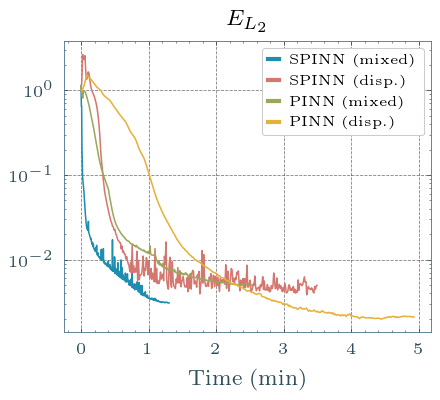

In [11]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

page_width = plt_cfg().page_width
# Example usage with all forward results
if results_forward:
    fig, ax_l2 = plt.subplots(1, 1, figsize=(page_width*0.5, page_width * 0.4), dpi=200)
    plot_metrics_comparison(
        results_forward, metric_name="L2 Error", 
        run_names=[config_text_dict.get(k, k) for k in results_forward.keys()],
        step_type="time", time_unit="min", ylabel="", ax=ax_l2
    )
    ax_l2.set_title(r"$E_{L_2}$")

    if save_fig:
        os.makedirs('./images/pgf', exist_ok=True)
        fig.savefig('./images/pgf/forward_metrics.pgf', bbox_inches='tight')
        fig.savefig('./images/forward_metrics.png', dpi=300, bbox_inches='tight')
        print(f"Saved: './images/forward_metrics.png'")